### Import Core Libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pyshred.models import SHRED # import SHRED
from pyshred.datasets import load_plasma # import plasma dataset

### Import Helper Library

In [2]:
%load_ext autoreload
%autoreload 2
from pyshred_pypi_helper import *

### Load Data

In [3]:
# load plasma data
plasma_data = load_plasma()
# Get number of timesteps (size of last dimension of array)
timesteps = plasma_data['Jex'].shape[-1]
# Selected number of hidden timesteps evaluate forecasting
test_timesteps = 50
training_timesteps = timesteps - test_timesteps
# Setup input dictionary 
data_Jex = plasma_data['Jex'][:,:,:-test_timesteps]
data_Jey = plasma_data['Jey'][:,:,:-test_timesteps]
data_Jez = plasma_data['Jez'][:,:,:-test_timesteps]
data = {
    'Jex' : data_Jex,
    'Jey' : data_Jey,
    'Jez' : data_Jez,
}
print('total timesteps:', timesteps)
print('training timesteps:', training_timesteps)
print('training data:')
for key, value in data.items():
    print(f"{key}: {value.shape}")

total timesteps: 2000
training timesteps: 1950
training data:
Jex: (50, 60, 1950)
Jey: (50, 60, 1950)
Jez: (50, 60, 1950)


### Load Sensor Data

In [4]:
# mobile sensor trajectory list
Jez_mobile_clockwise_perimeter_walk_cw = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = data_Jez.shape[2], clockwise=True)
Jez_mobile_clockwise_perimeter_walk_ccw = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = data_Jez.shape[2], clockwise=False)
# Create sensors dictionary
sensor = {
    'Jex' : 3, # random stationary sensors
    'Jey' : [(0,0), (49,59)], # selected stationary sensors
    'Jez' : [Jez_mobile_clockwise_perimeter_walk_cw, Jez_mobile_clockwise_perimeter_walk_ccw] # mobile sensors
}

### Initialize and Fit SHRED

In [5]:
lags = 40
num_epochs = 1000
shred = SHRED(sequence='LSTM', decoder='SDN')
val_errors,  sensor_forecast_errors = shred.fit(data = data, sensors = sensor, num_epochs=num_epochs, lags=lags, n_components=None) # by default: compressed = True, sensor_forecaster = True

Version:  {15}
Done.

Fitting Reconstructor...


Epoch 474/1000: 100%|██████████| 24/24 [00:01<00:00, 23.04batch/s, loss=0.00211, L2=0.0941, val_loss=0.00192, val_L2=0.0898]


Early stopping triggered: patience threshold reached.

Fitting Forecaster...


Epoch 160/1000: 100%|██████████| 24/24 [00:00<00:00, 51.14batch/s, loss=0.00106, L2=0.0582, val_loss=0.000771, val_L2=0.05]


Early stopping triggered: patience threshold reached.


### SHRED Attributes

In [6]:
print(shred)

SHRED(
  (_reconstructor): _SHRED(
    (_sequence_model): LSTMSequence(
      (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
    )
    (_decoder_model): SDN(
      (linear1): Linear(in_features=64, out_features=350, bias=True)
      (linear2): Linear(in_features=350, out_features=400, bias=True)
      (linear3): Linear(in_features=400, out_features=9007, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (_sensor_forecaster): _SHRED(
    (_sequence_model): LSTMSequence(
      (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
    )
    (_decoder_model): SDN(
      (linear1): Linear(in_features=64, out_features=350, bias=True)
      (linear2): Linear(in_features=350, out_features=400, bias=True)
      (linear3): Linear(in_features=400, out_features=7, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


In [7]:
shred.summary()

                    SHRED Model Results                     
                       Reconstructor                        
Sequence:                     LSTM
Decoder:                      SDN
Validation Error (L2):        0.089
------------------------------------------------------------
                     Sensor Forecaster                      
Sequence:                     LSTM
Decoder:                      SDN
Validation Error (L2):        0.050
No. Observations:             1950
No. Sensors:                  7
Time:                         (start: 0, end: 1949, by: 1)
Lags (timesteps):             40
Compression:                  False



In [8]:
shred.sensor_summary

row index dataset        type  \
0          0     Jex  stationary   
1          1     Jex  stationary   
2          2     Jex  stationary   
3          3     Jey  stationary   
4          4     Jey  stationary   
5          5     Jez      mobile   
6          6     Jez      mobile   

                                 location/trajectory  
0                                            (29, 4)  
1                                           (35, 33)  
2                                           (28, 50)  
3                                             (0, 0)  
4                                           (49, 59)  
5  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...  
6  [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0...

In [9]:
shred.sensor_data

array([[ -293.59444437,    39.15158319,    46.24303044, ...,
         -761.33967996,  -720.63496718,  -594.24398294],
       [  452.62112071,    13.97495075,    31.04196598, ...,
         1947.91007792,  1830.39669524,  1531.80146411],
       [ -783.62272095,   -66.91923372,   -29.43290736, ...,
          -75.07348802,   112.87246266,   -17.42505882],
       ...,
       [ -383.74      ,  -129.14      ,    30.434     , ...,
         1027.        ,  1357.        ,  1663.1       ],
       [-1453.1       , -3887.15490316, -4098.75946589, ...,
        -5057.64311119, -5612.58541605, -6168.47986406],
       [-1453.1       , -3523.02730247, -3521.71319588, ...,
        -3280.99034727, -3134.81407316, -2665.03053008]])

### Get sensor measurements for all data (trainining + testing)

In [10]:
row0 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][0][0], shred.sensor_summary['location/trajectory'][0][1], :]
row1 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][1][0], shred.sensor_summary['location/trajectory'][1][1], :]
row2 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][2][0], shred.sensor_summary['location/trajectory'][2][1], :]
row3 = plasma_data['Jey'][shred.sensor_summary['location/trajectory'][3][0], shred.sensor_summary['location/trajectory'][3][1], :]
row4 = plasma_data['Jey'][shred.sensor_summary['location/trajectory'][4][0], shred.sensor_summary['location/trajectory'][4][1],:]
row5_coords = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = timesteps, clockwise=True)
row5 = []
for t, (x, y) in enumerate(row5_coords):
    row5.append(plasma_data['Jez'][x, y, t])

row6_coords = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = timesteps, clockwise=False)
row6 = []
for t, (x, y) in enumerate(row6_coords):
    row6.append(plasma_data['Jez'][x, y, t])

all_sensor_data = stacked_array = np.vstack((row0, row1, row2, row3, row4, row5, row6))
print('Check if portion of `all_sensor_data` aligns with `shred.sensor_data`: ',np.allclose(all_sensor_data[:,:-test_timesteps], shred.sensor_data))

Check if portion of `all_sensor_data` aligns with `shred.sensor_data`:  True


### Predict (in-sample reconstruction)

In [11]:
start = 1900 # inclusive
end = 1949 # inclusive
recon = shred.predict(start = start, end = end)

In [12]:
print(recon.recon_dict)

{'sensors': array([[-6.88307739e+02, -7.49470337e+02, -7.20036133e+02,
        -6.92518066e+02, -6.79778076e+02, -6.58155640e+02,
        -5.78526733e+02, -3.81233398e+02, -2.27994507e+02,
        -9.56561737e+01,  9.17423401e+01,  2.78072571e+02,
         3.45167328e+02,  3.66911835e+02,  3.49402344e+02,
         3.13203522e+02,  2.43109055e+02,  1.26756126e+02,
         1.31395569e+01, -8.42538834e+01, -2.08089508e+02,
        -3.53087677e+02, -4.53576904e+02, -4.43417511e+02,
        -3.87234863e+02, -2.50658295e+02, -1.26829277e+02,
        -3.56101341e+01, -7.30037355e+00, -5.46819801e+01,
        -1.04827995e+02, -1.63990616e+02, -2.30246307e+02,
        -2.62968231e+02, -2.96623047e+02, -3.51259247e+02,
        -4.27977264e+02, -5.48797363e+02, -6.09152832e+02,
        -5.65171387e+02, -4.89495422e+02, -5.67002197e+02,
        -6.69600220e+02, -7.30378540e+02, -8.63896973e+02,
        -8.88849060e+02, -8.37332336e+02, -7.82270752e+02,
        -7.42145142e+02, -7.04185120e+02],
 

In [13]:
print(recon.sensor_measurements) # includes all sensor measurements used for `predict` (e.g. lags + predicted sensor measurements)

[[-4.26636780e+02 -4.65351622e+02 -5.35114325e+02 -6.89029323e+02
  -7.19875114e+02 -7.58494715e+02 -6.14451774e+02 -3.57581700e+02
  -1.39838143e+02 -2.61529542e+01  1.58729973e+02  3.32898205e+02
   6.36950388e+02  7.19408750e+02  9.92649675e+02  1.24836112e+03
   1.34475726e+03  1.51505001e+03  1.60169357e+03  1.61869903e+03
   1.24652369e+03  8.85103204e+02  6.25262399e+02  1.51340513e+02
  -1.96578054e+02 -5.99587328e+02 -9.29773424e+02 -9.86751462e+02
  -1.06349559e+03 -1.15604640e+03 -1.22151487e+03 -1.40625551e+03
  -1.11413959e+03 -7.77312311e+02 -7.34708830e+02 -7.90359575e+02
  -6.69784616e+02 -7.83648092e+02 -6.96302355e+02 -7.37109920e+02
  -7.79518780e+02 -7.91506812e+02 -9.43433095e+02 -8.48173629e+02
  -6.87800540e+02 -5.06858606e+02 -1.57844731e+02  4.10463492e+01
   2.16173869e+02  3.68992431e+02  4.13662735e+02  3.05732724e+02
   2.68408419e+02  9.34107702e+01  4.68149693e+00  8.98565762e+01
   1.73347517e+02  1.95791128e+02 -2.75264575e+01 -2.56909676e+02
  -3.95811

In [14]:
print(recon.time) # times of predicted sensor measurements

[1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949]


Plot recon vs. truth at a single timestep

Compare Jex:


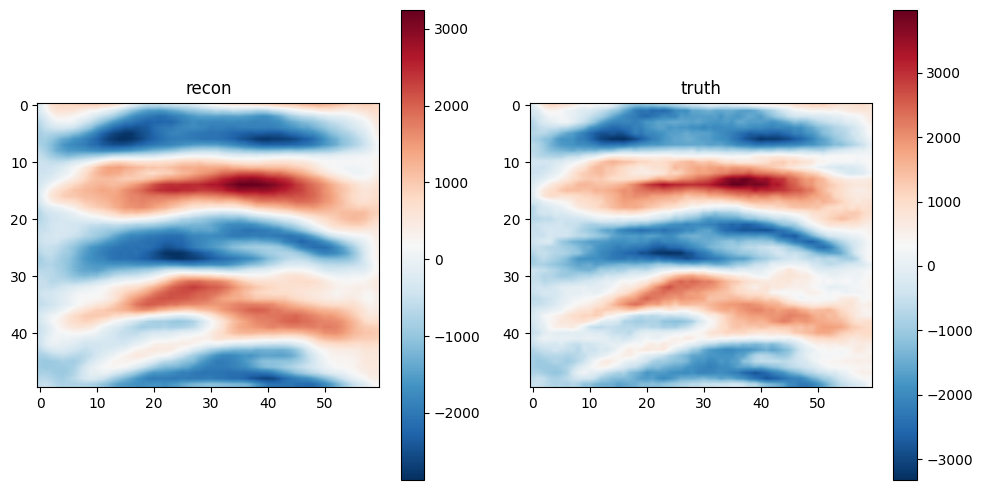

Compare Jey:


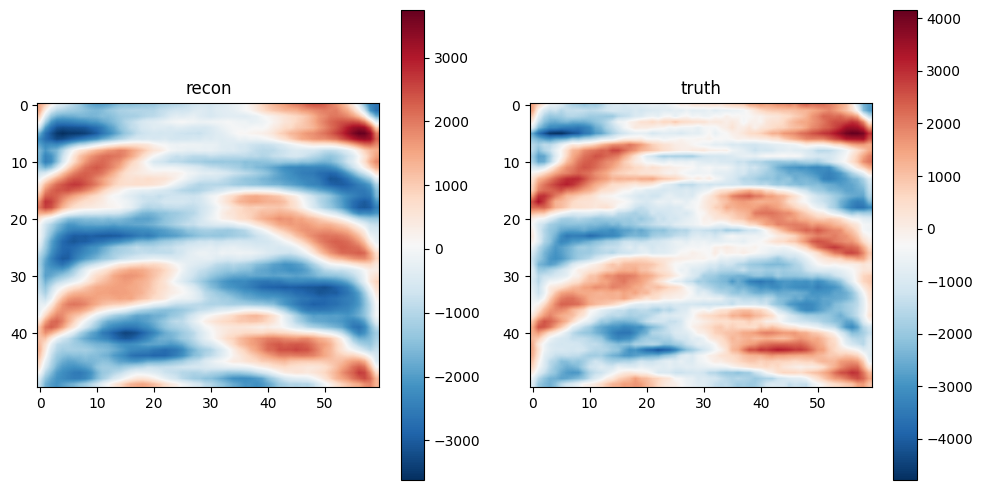

Compare Jez:


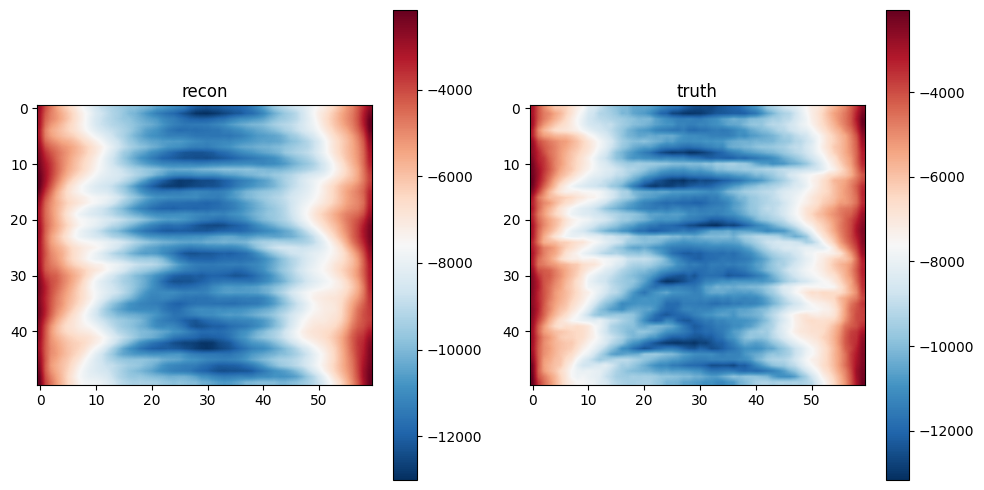

In [15]:
recon_timestep = 1945
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

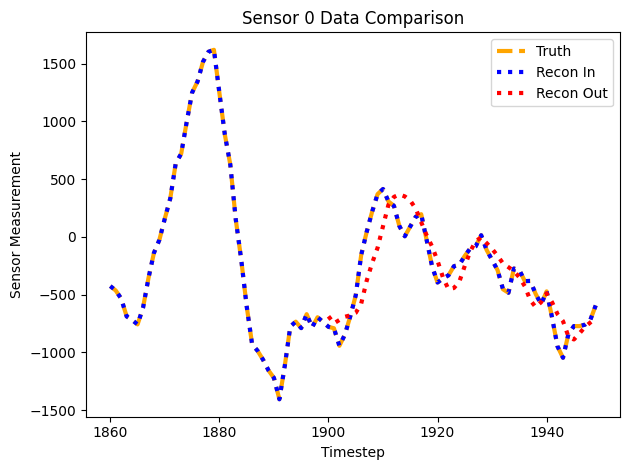

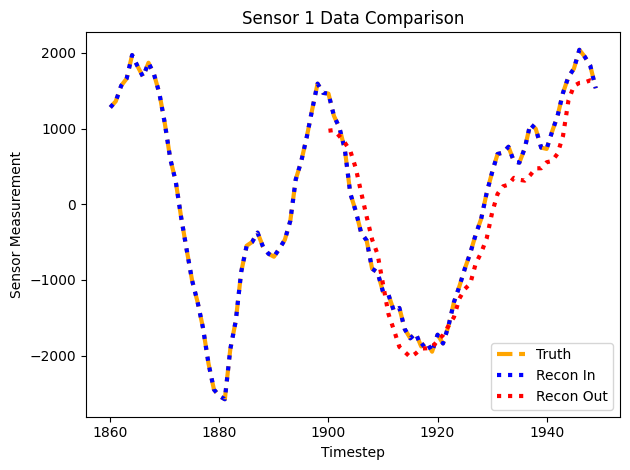

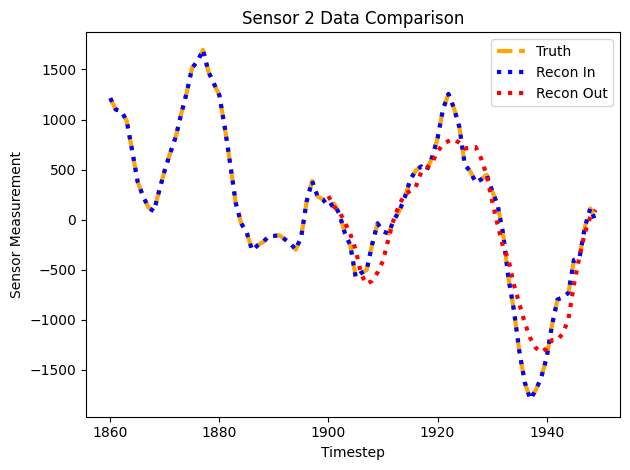

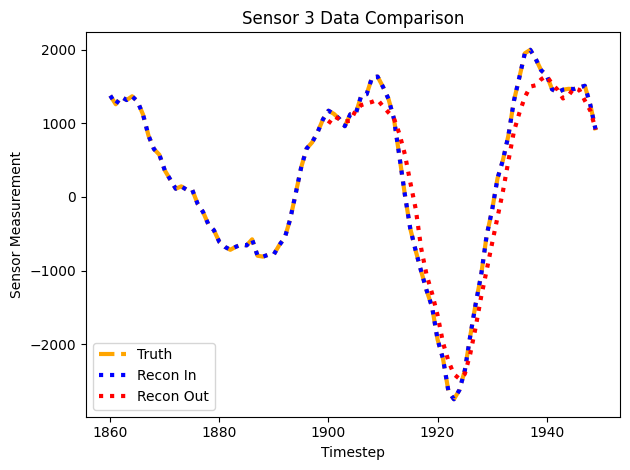

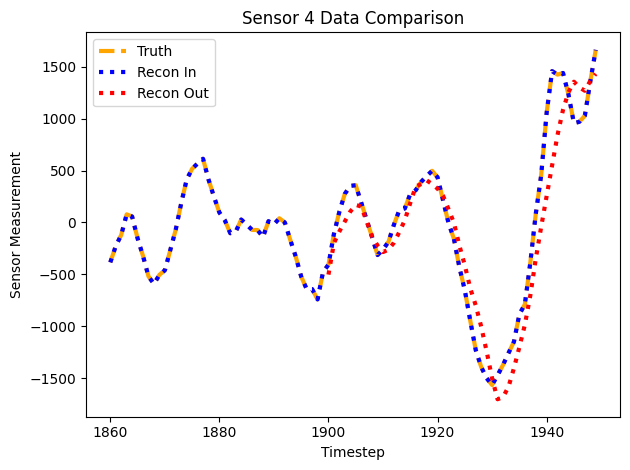

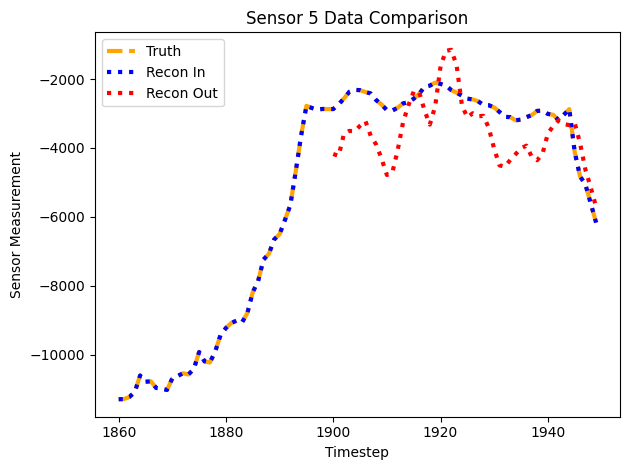

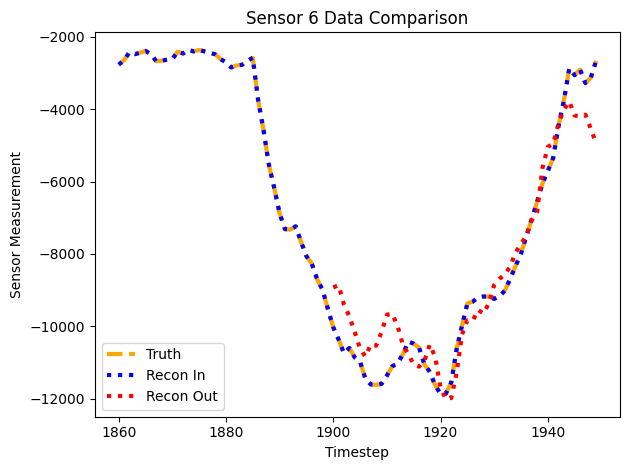

In [16]:
######## Plot without lags included ###############################
# for i in range (all_sensor_data.shape[0]):
#     truth = all_sensor_data[i,start:end+1]
#     # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
#     recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
#     recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
#     plt.figure()
#     # Plot truth, recon_in, and recon_out on the same plot
#     plt.plot(truth, label='Truth', color='orange', linestyle='--', linewidth=3)
#     plt.plot(recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
#     plt.plot(recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
#     # Add labels and legend
#     plt.xlabel('Timestep')
#     plt.ylabel('Sensor Measurement')
#     plt.title(f'Sensor {i} Data Comparison')
#     plt.legend()
#     # Display the plot
#     plt.tight_layout()
#     plt.show()

######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()


### Predict (out-of-sample reconstruction without additional sensor data)

In [17]:
start = 1950
end = 1999
recon = shred.predict(start = start, end = end)

Plot recon vs. truth at a single timestep

Compare Jex:


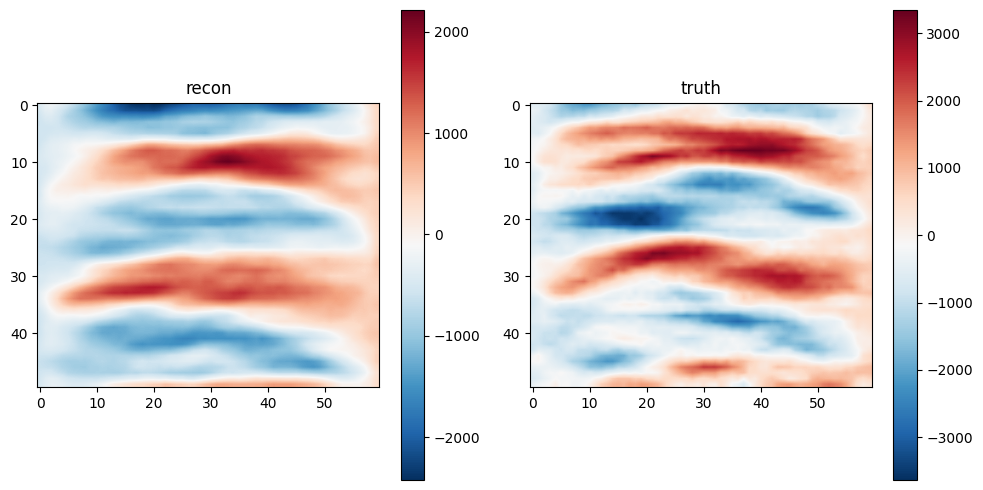

Compare Jey:


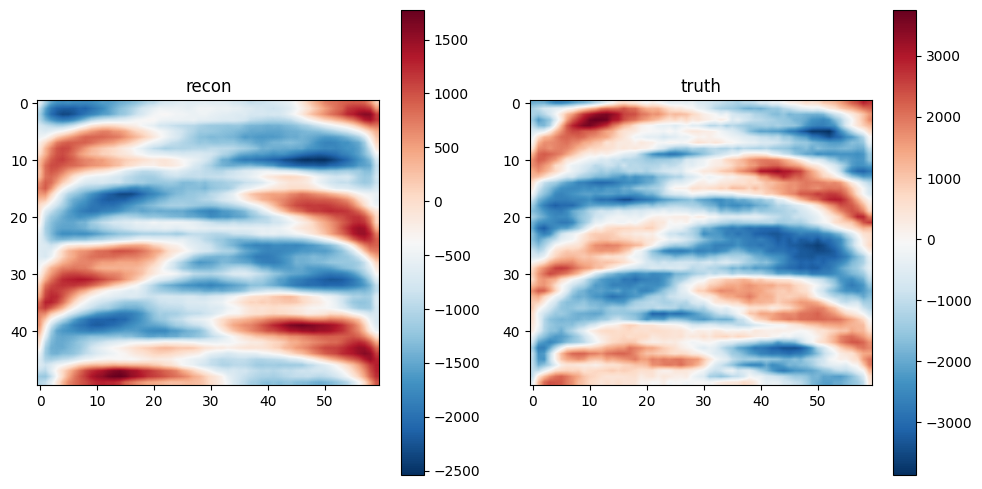

Compare Jez:


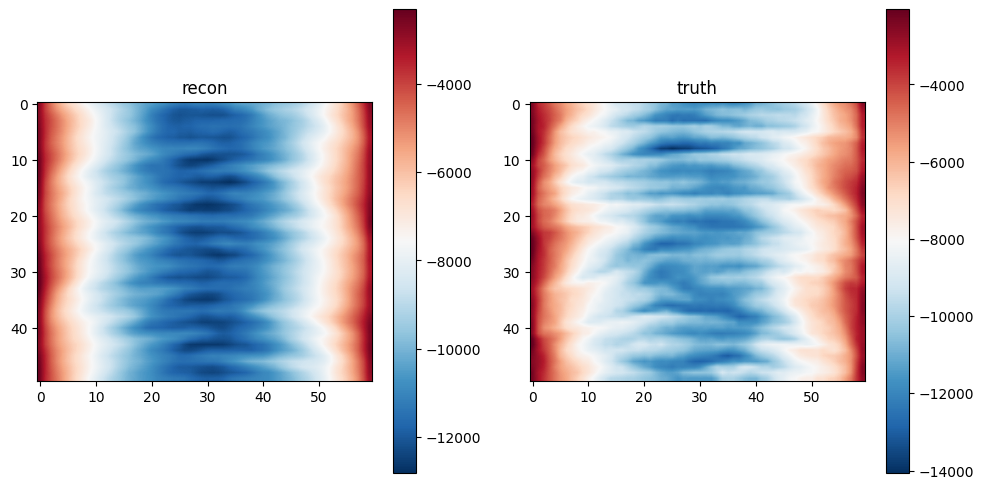

In [18]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

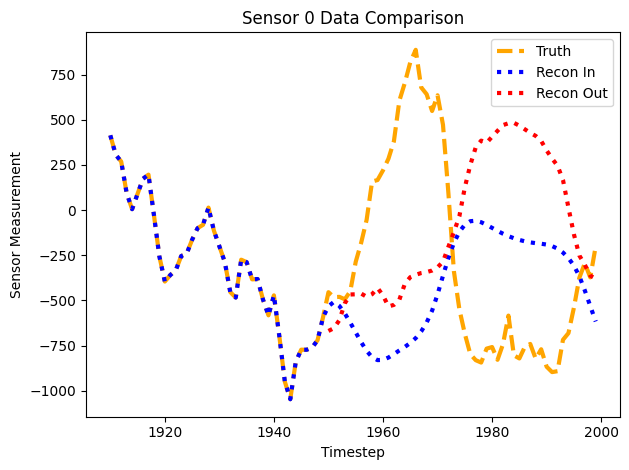

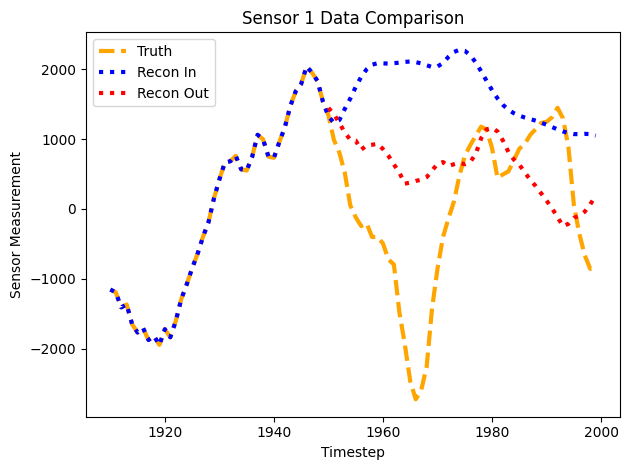

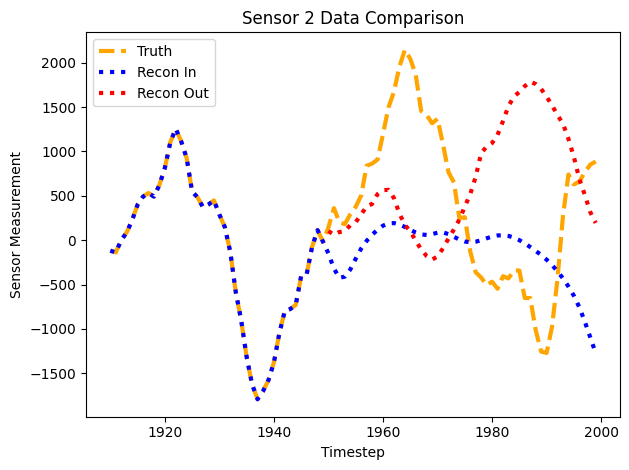

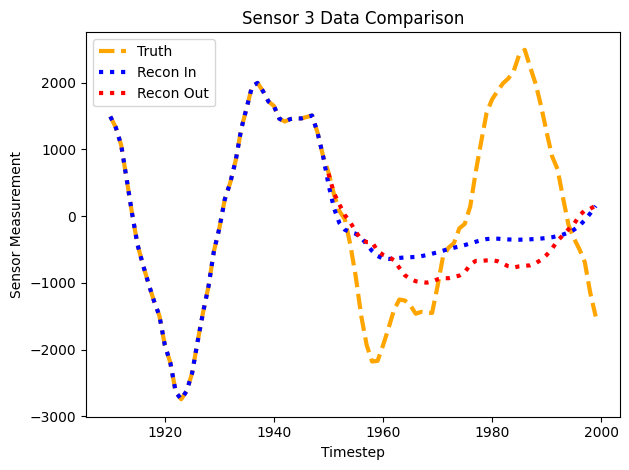

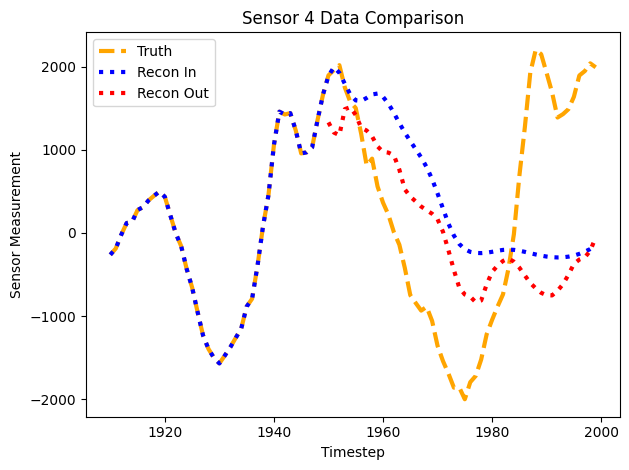

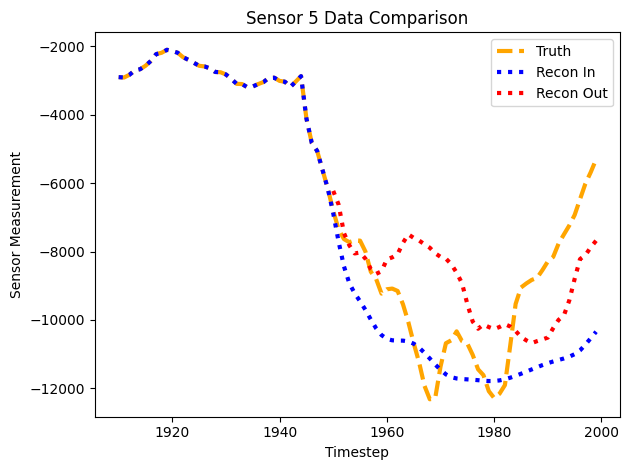

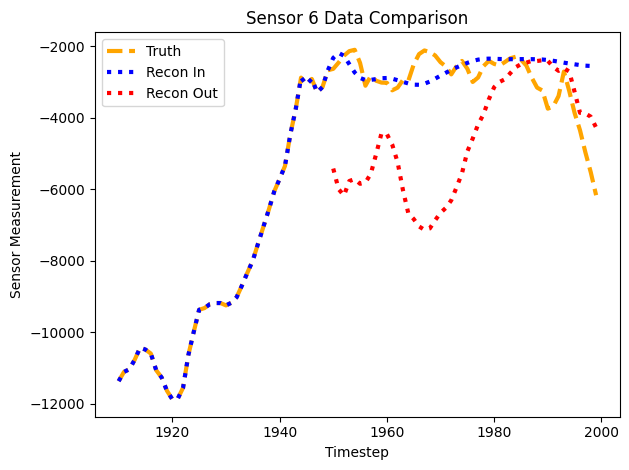

In [19]:
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



### Predict (out-of-sample with additional sensor data)

In [20]:
start = 1950
end = 1999
recon = shred.predict(start = start, end = end, sensor_data=all_sensor_data, sensor_data_time=np.arange(0,timesteps))

Compare Jex:


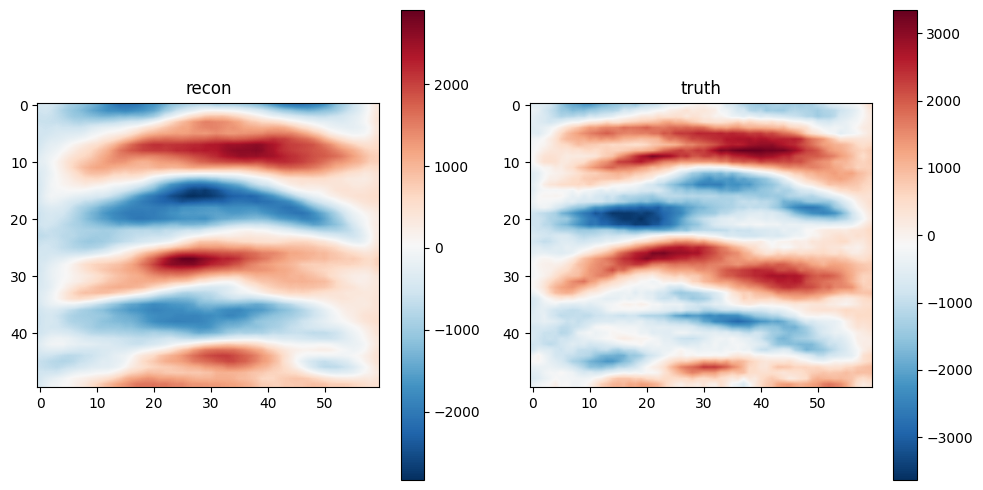

Compare Jey:


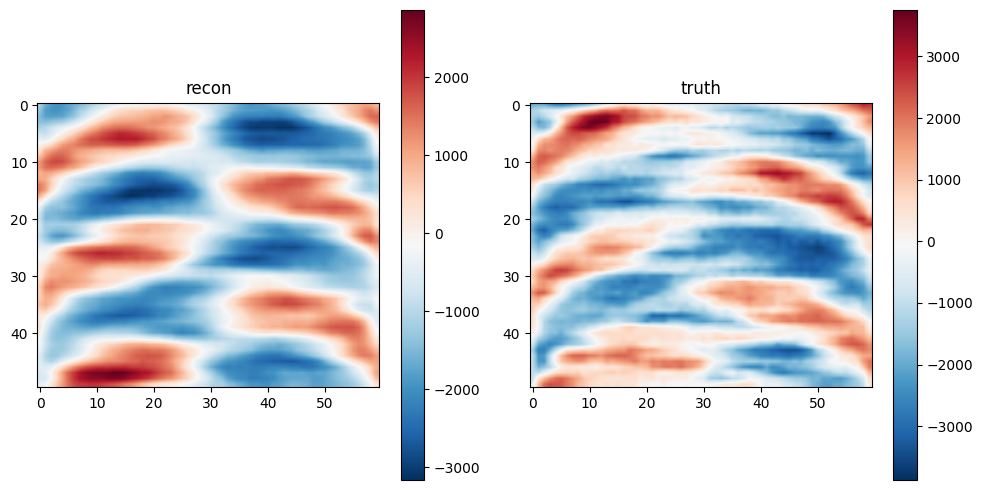

Compare Jez:


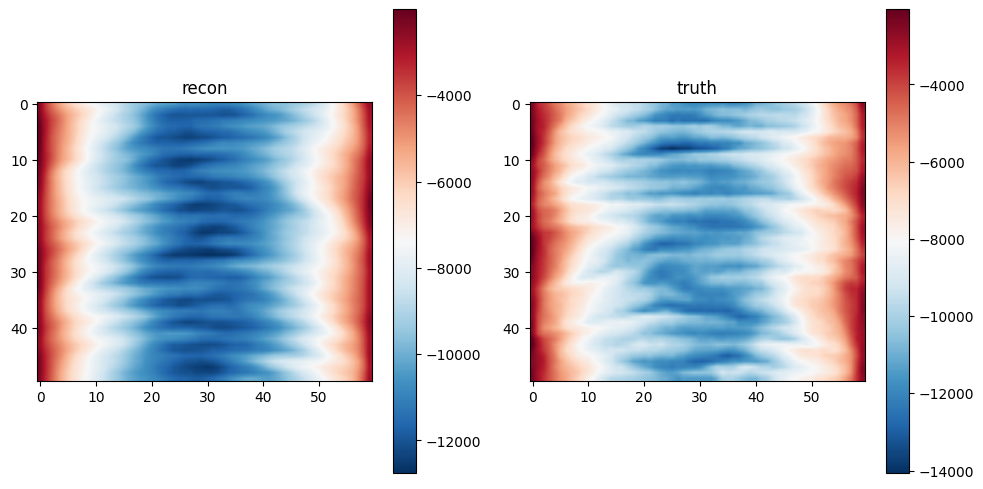

In [21]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

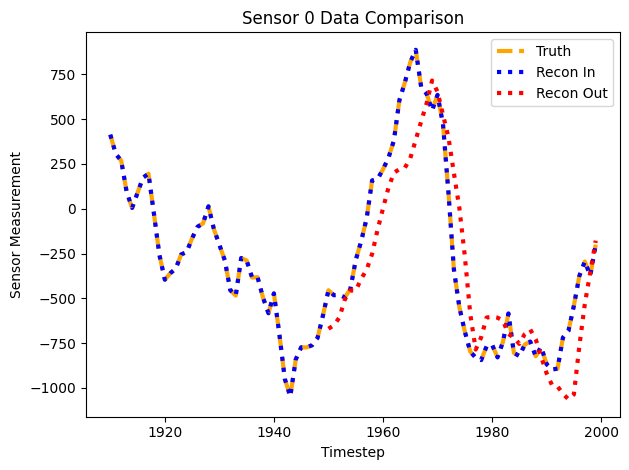

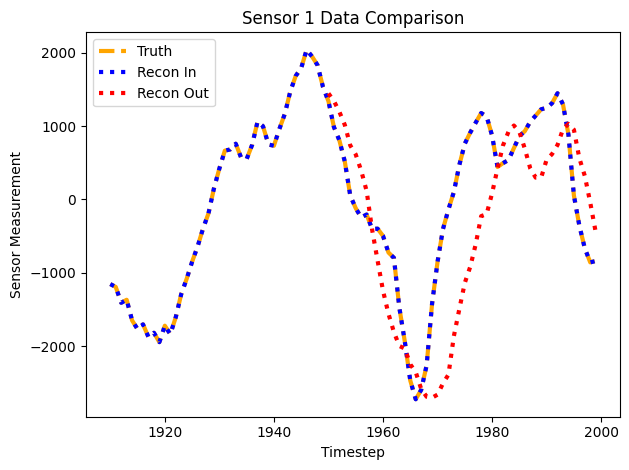

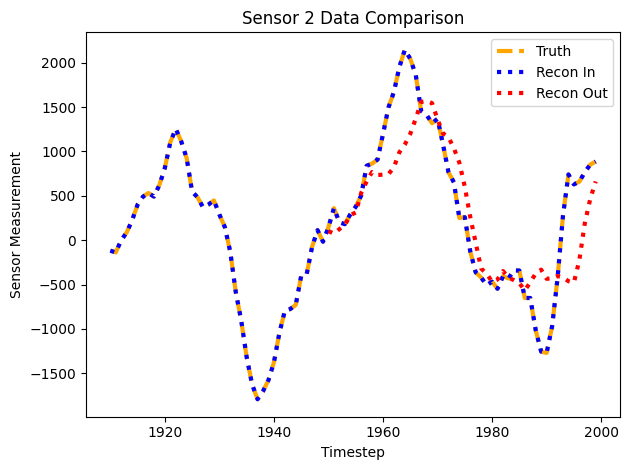

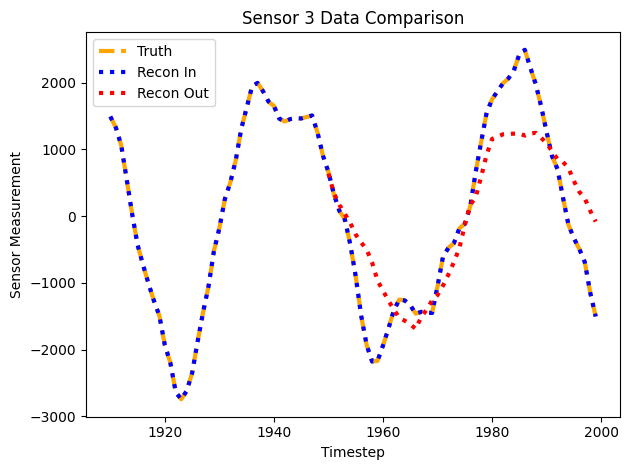

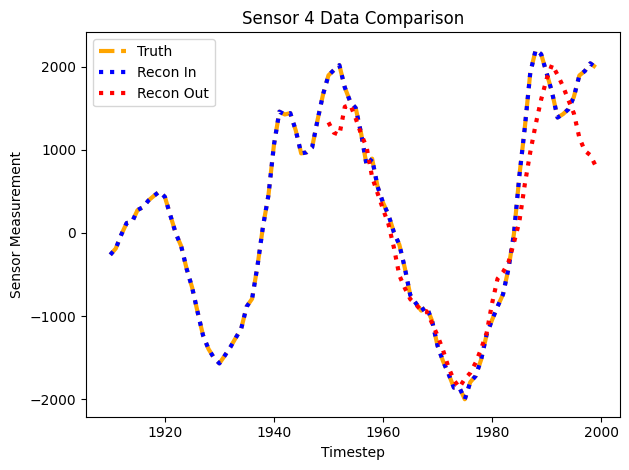

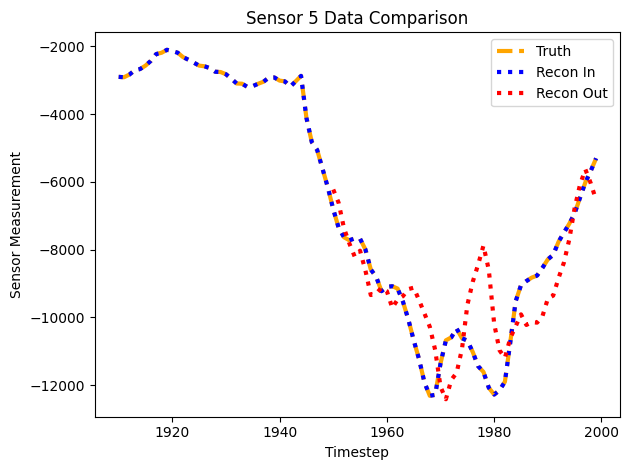

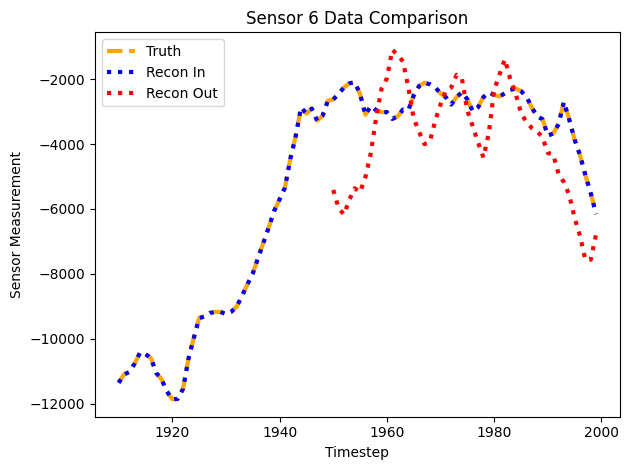

In [22]:
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



### Recon (uses only the sensor measurements passed in to perform reconstructions)

In [23]:
recon = shred.recon(all_sensor_data[:,0:training_timesteps]) # only the sensor measurements passed in are used for reconstruction
                                                   # number of reconstructions equals length of sensor data minus lags

Compare Jex:


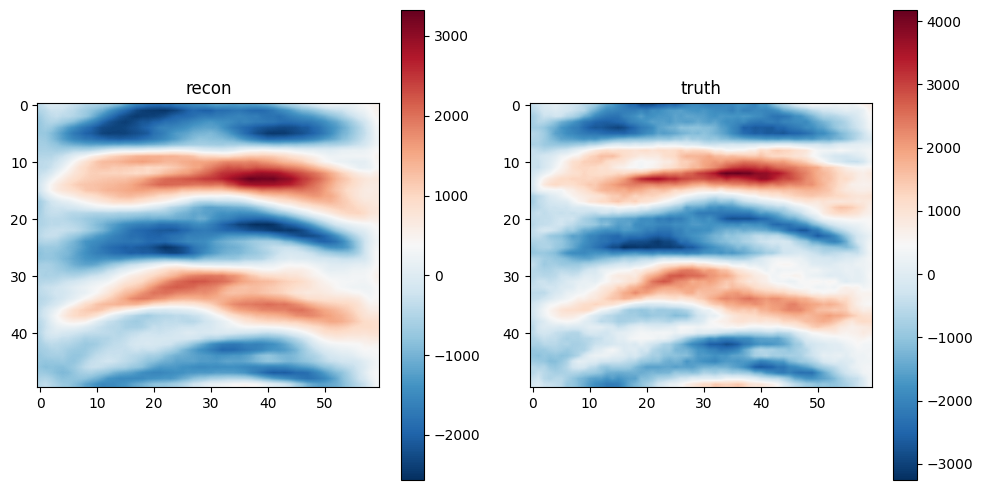

Compare Jey:


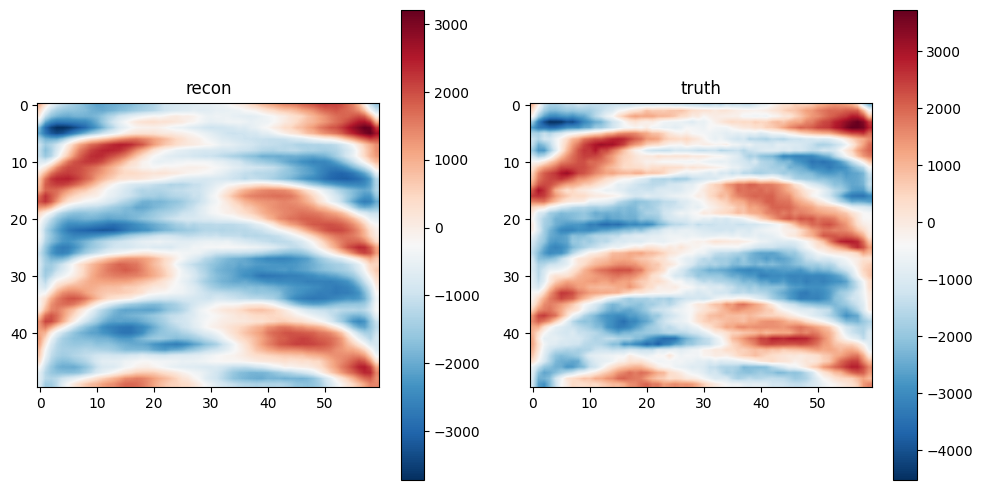

Compare Jez:


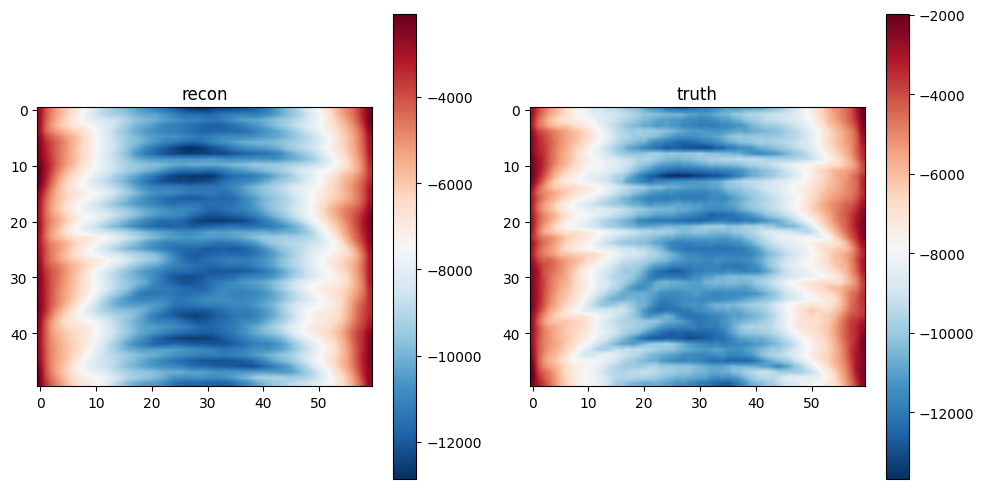

In [24]:
recon_index = 1909
jex_recon = recon['Jex'][:,:,recon_index]
jey_recon = recon['Jey'][:,:,recon_index]
jez_recon = recon['Jez'][:,:,recon_index]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_index+lags])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_index+lags])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_index+lags])

C:\Users\David\AppData\Local\Temp\ipykernel_173784\3802679832.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f'Sensor: {shred.sensor_summary.iloc[i][1]} {shred.sensor_summary.iloc[i][2]}')


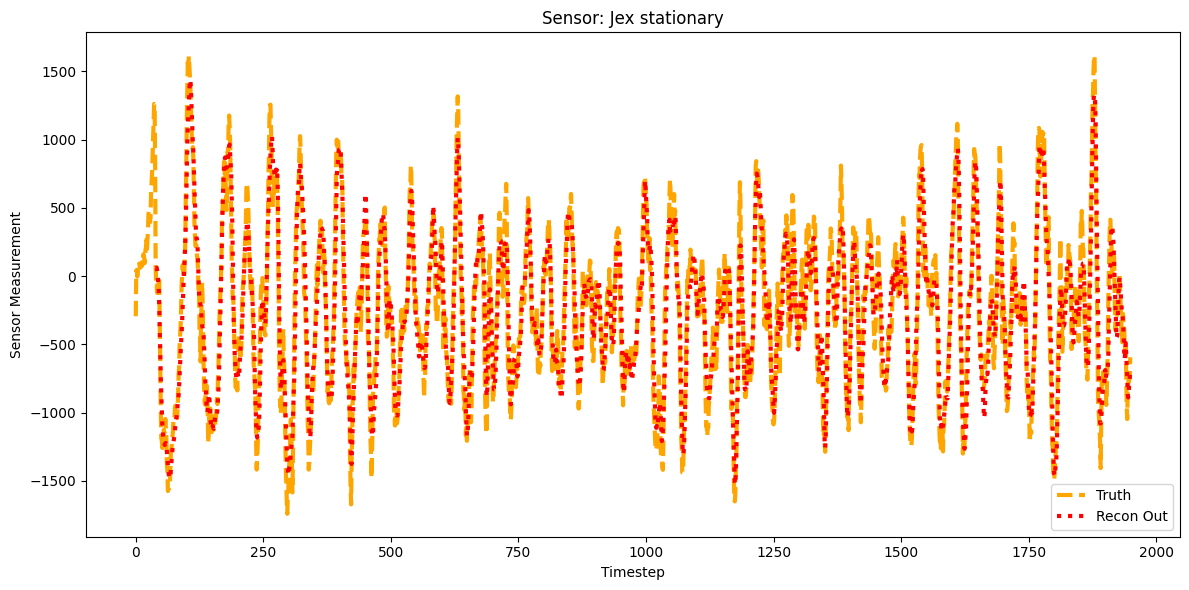

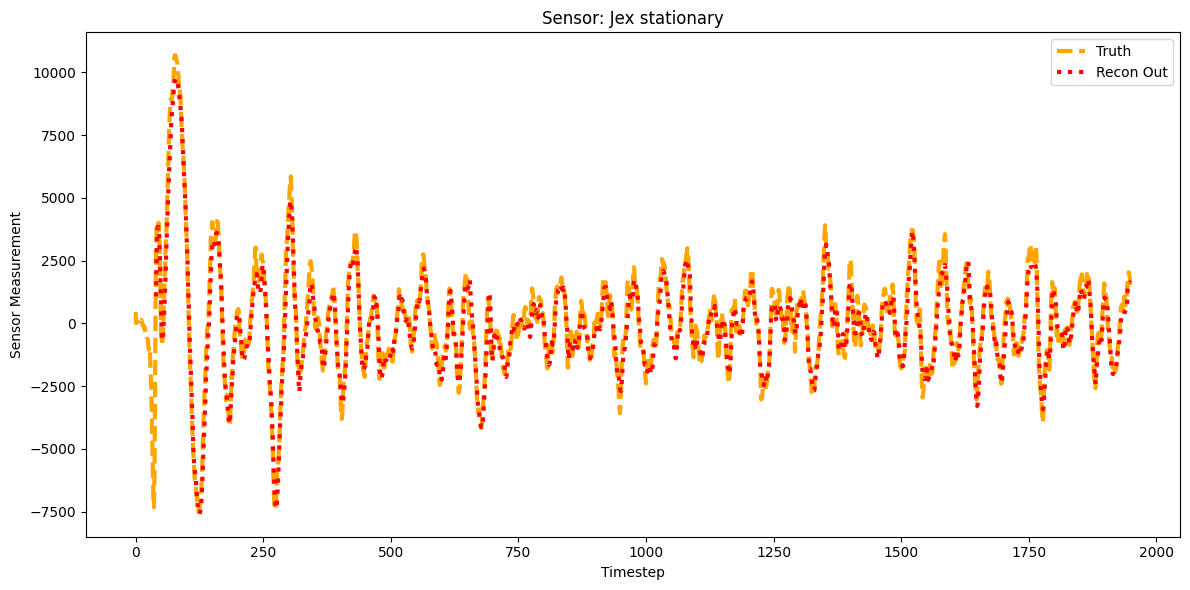

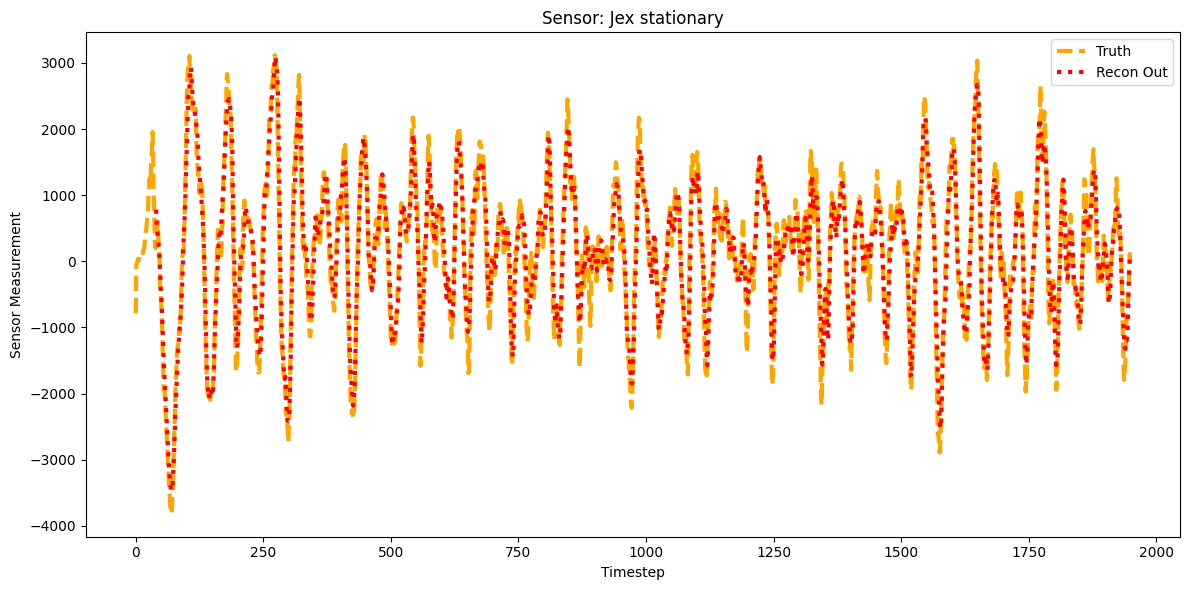

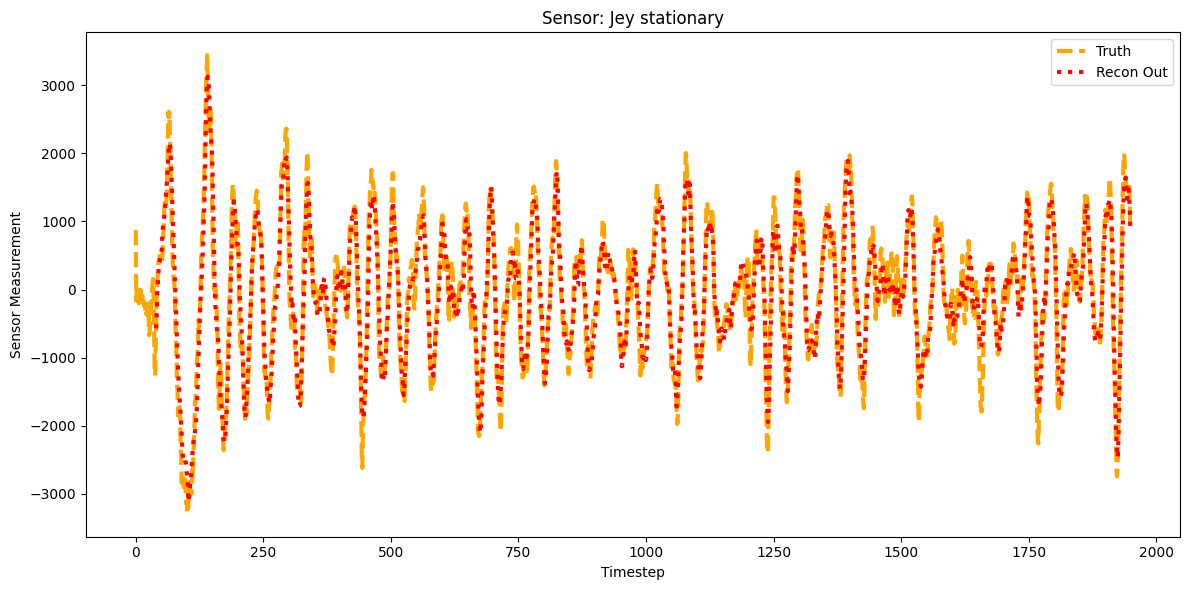

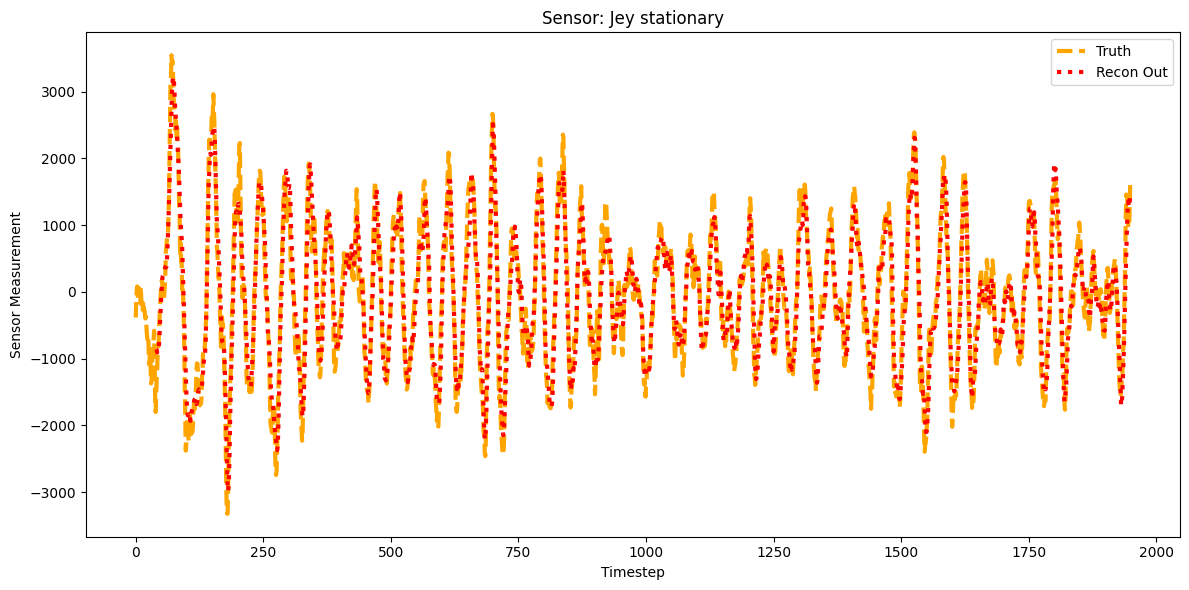

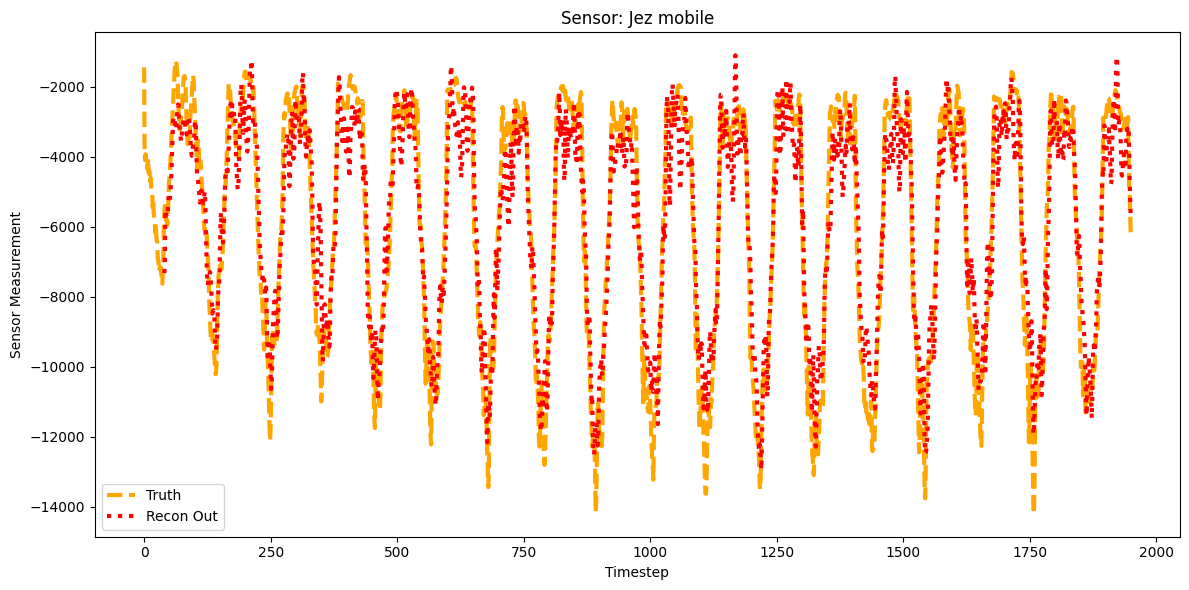

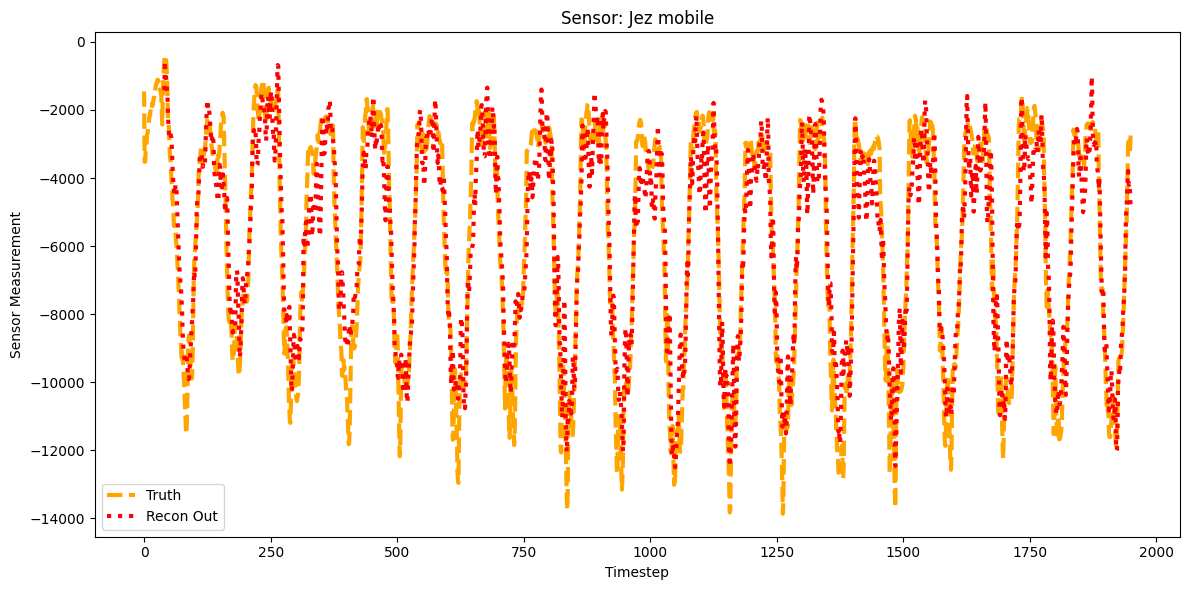

In [25]:
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,0:training_timesteps]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    # recon_in = recon.sensor_measurements[i]
    recon_out = recon['sensors'][i]
    plt.figure(figsize=(12, 6))
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(shred._time[0], shred._time[-1] + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    # plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(np.where(shred._time==lags)[0][0], shred._time[-1] + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor: {shred.sensor_summary.iloc[i][1]} {shred.sensor_summary.iloc[i][2]}')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



### Forecast (without additional data)

In [26]:
recon = shred.forecast(50)
start = recon.time[0]
end = recon.time[-1]


Compare Jex:


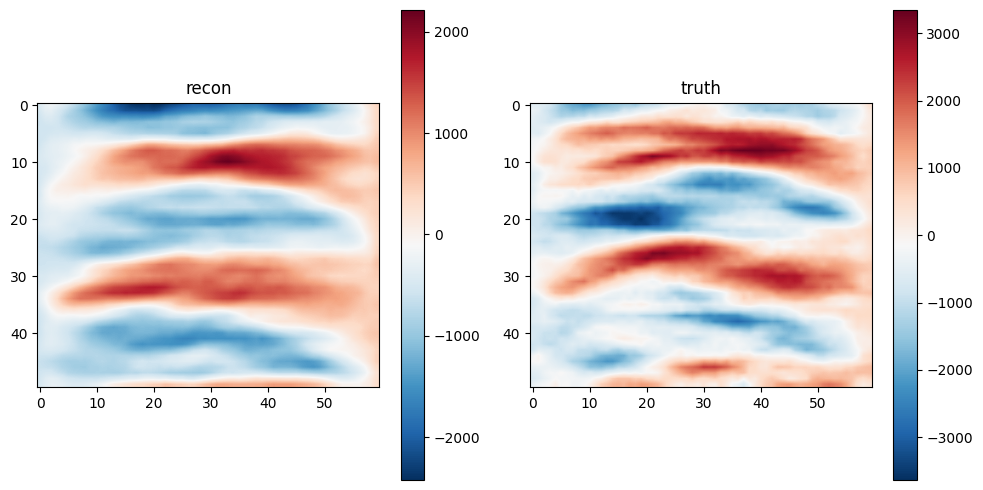

Compare Jey:


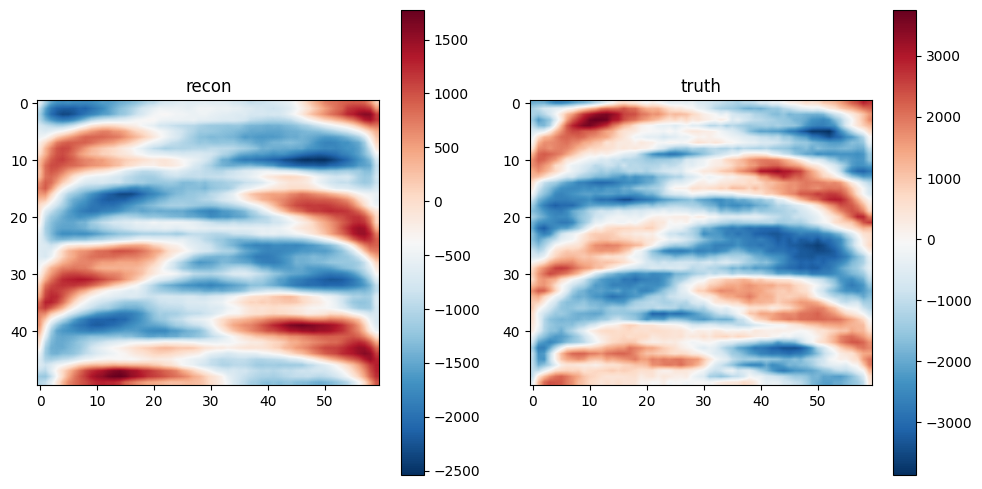

Compare Jez:


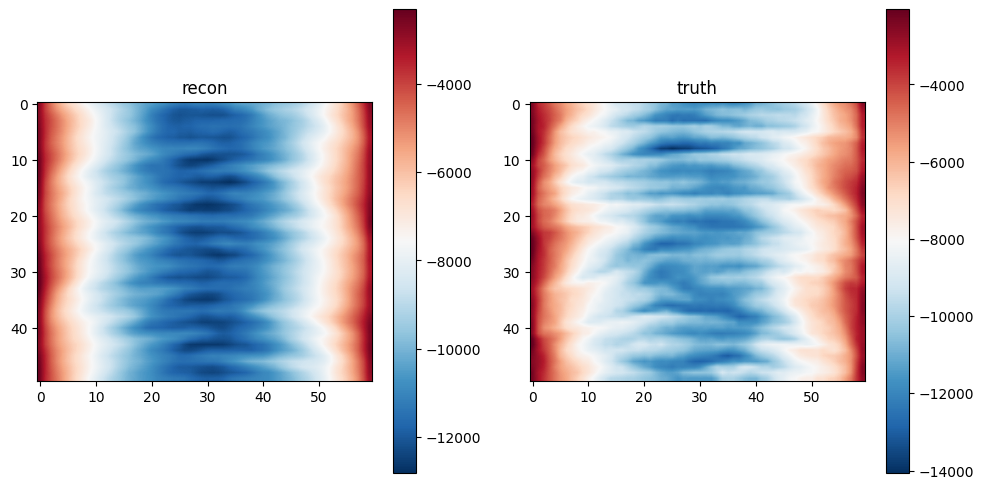

In [27]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

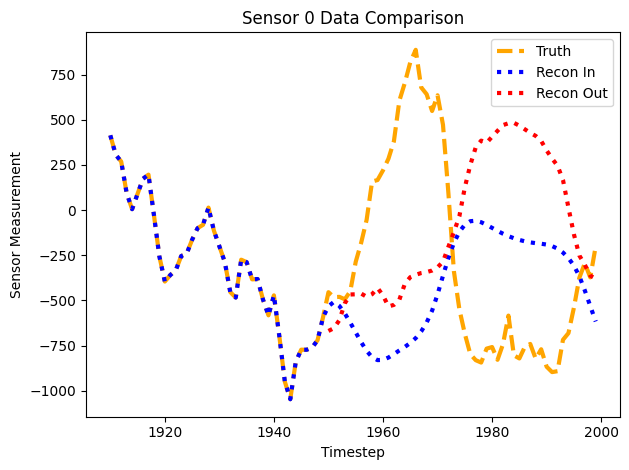

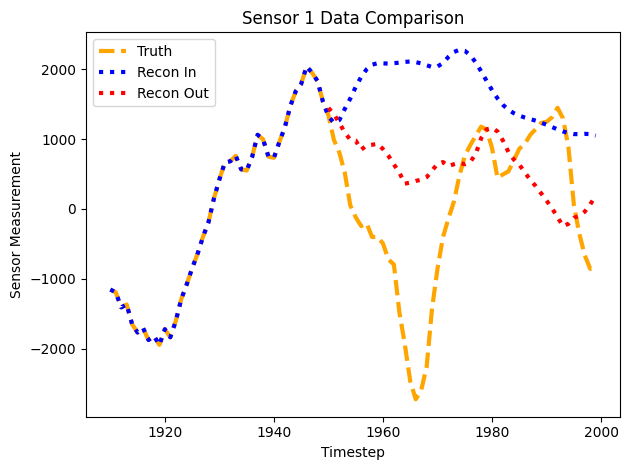

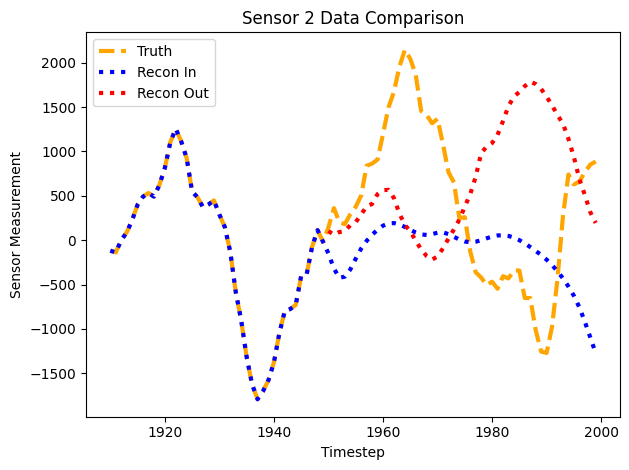

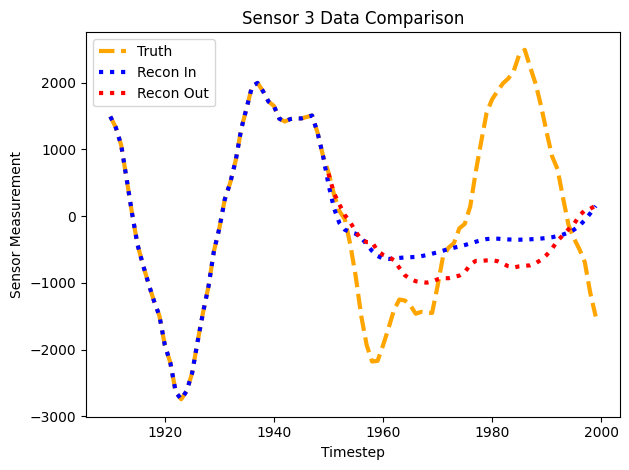

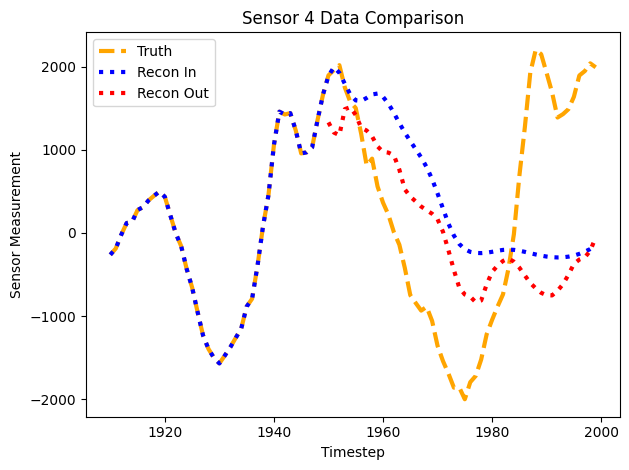

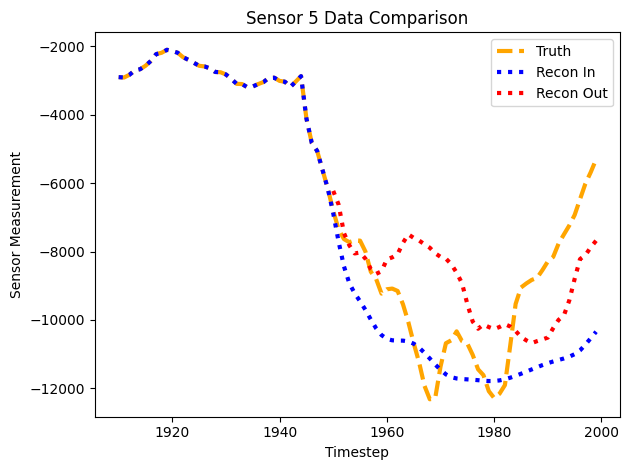

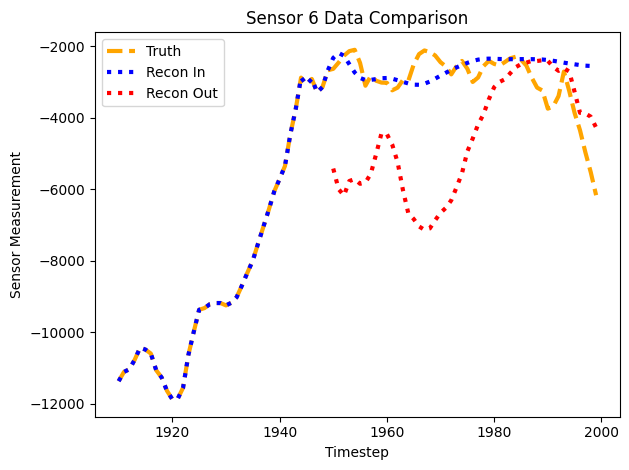

In [28]:
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



### Forecast (without additional data)

In [29]:
recon = shred.forecast(50, sensor_data=all_sensor_data, sensor_data_time=np.arange(0,timesteps))
start = recon.time[0]
end = recon.time[-1]

Compare Jex:


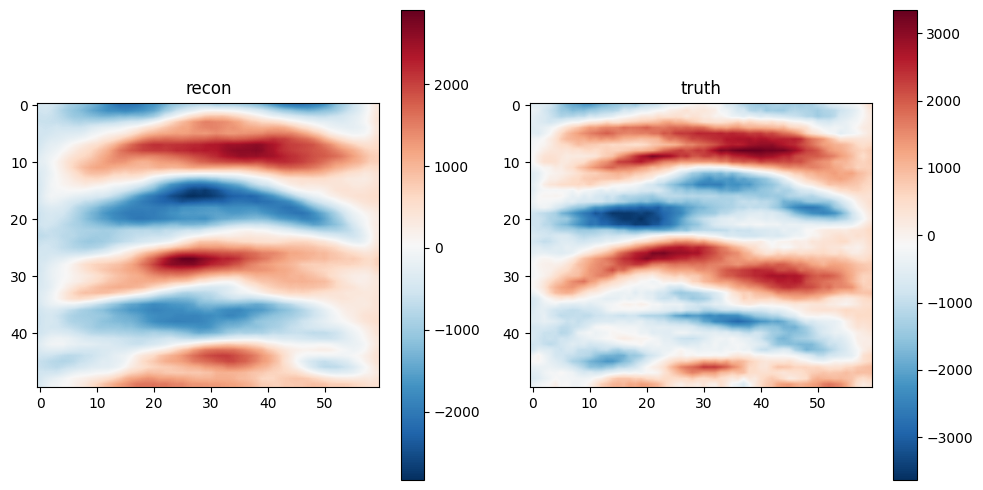

Compare Jey:


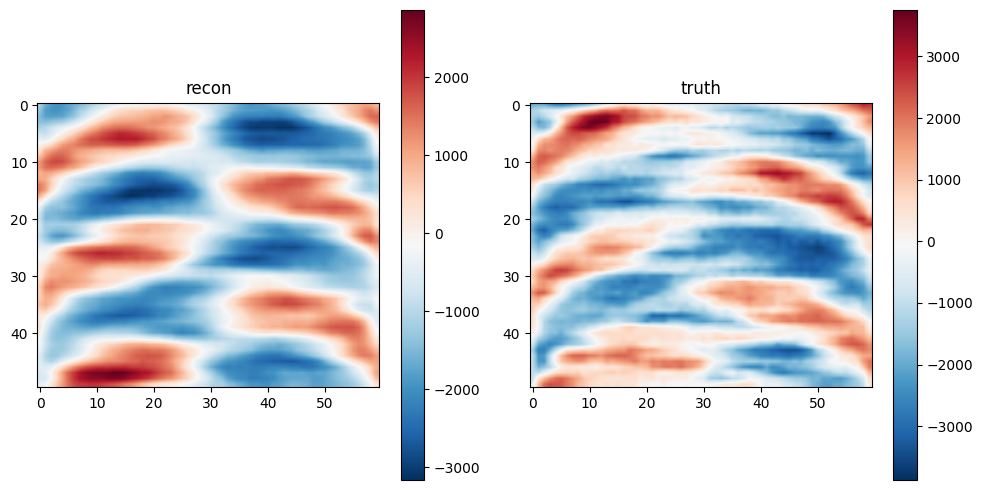

Compare Jez:


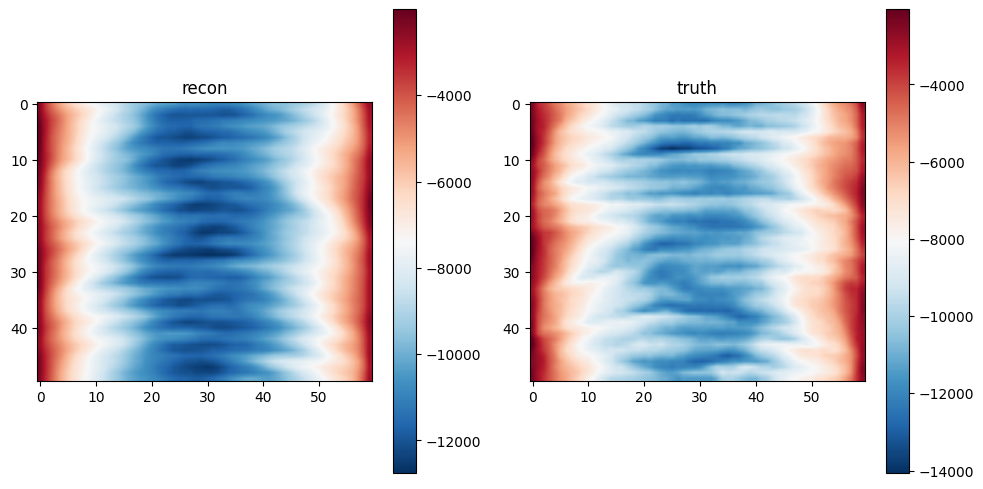

In [30]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

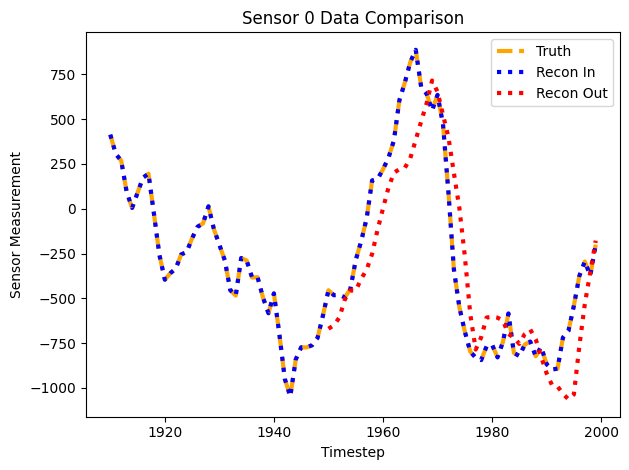

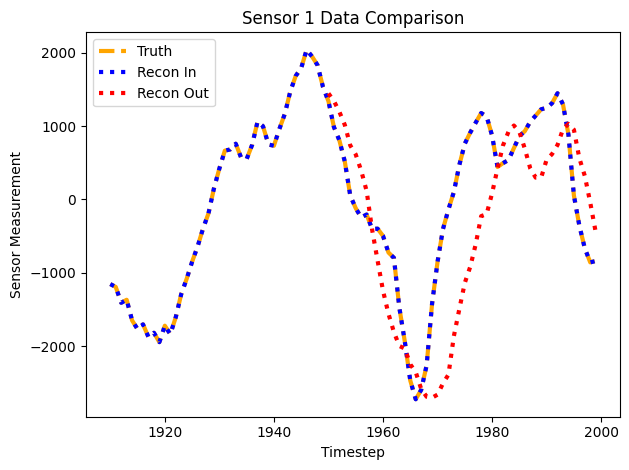

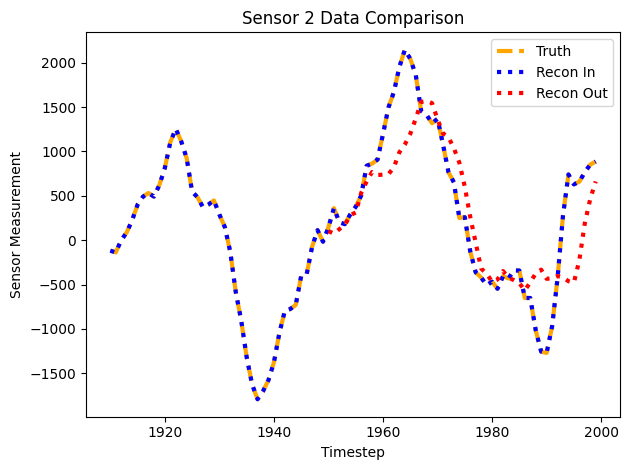

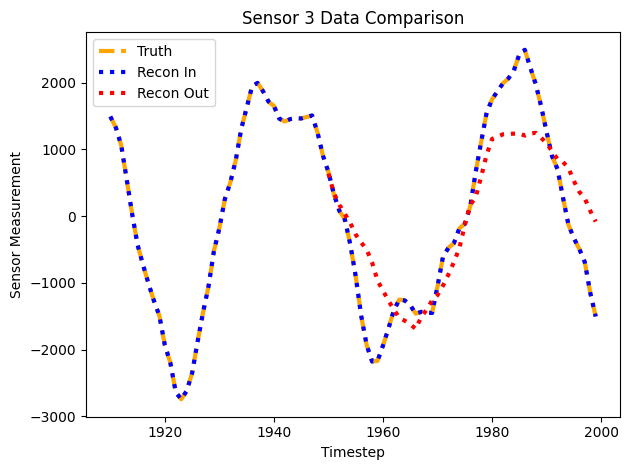

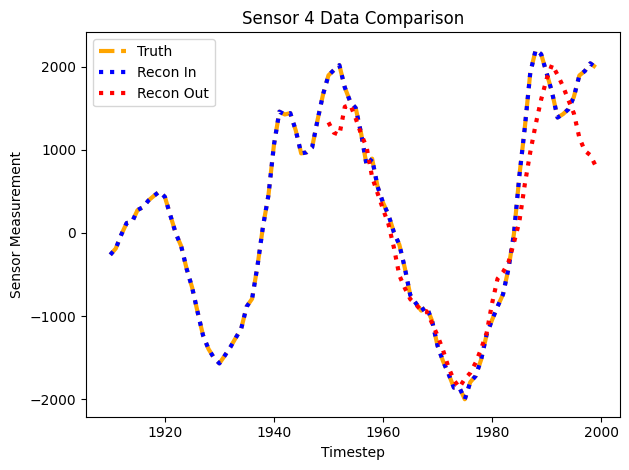

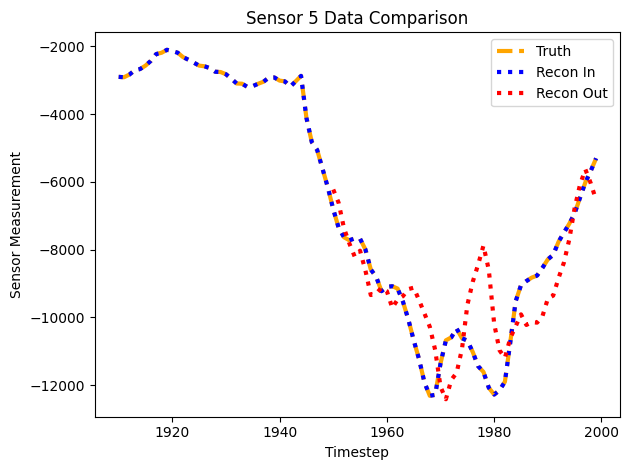

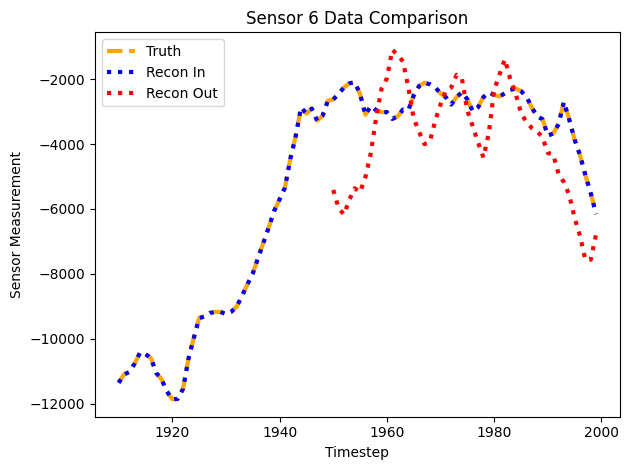

In [31]:
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()

